# 2. Déploiement et quantization avec onnx

## Partie 1

### 1. Entraîner un réseau de neurone convolutionnel de petite taille

In [993]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='data/', train=False, download=True, transform=transform)

train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=1000)

In [994]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Size images: {train_dataset[0][1]}")
print(f"Number of classes: {len(train_dataset.classes)}")

Number of training samples: 60000
Number of test samples: 10000
Size images: 5
Number of classes: 10


In [1020]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
    def compile(self, optimizer, criterion):
        self.optimizer = optimizer
        self.criterion = criterion
    
    def fit(self, train_loader, epochs=1):
        self.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for batch_idx, (data, target) in enumerate(train_loader):
                self.optimizer.zero_grad()
                output = self(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
            avg_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    def evaluate(self, test_loader):
        self.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = self(data)
                _, predicted = torch.max(output.data, 1)
                correct += (predicted == target).sum().item()
        return correct / len(test_loader.dataset)
    
    def export_onnx(self, file_name):
        self.eval()
        dummy_input = torch.randn(1, 1, 28, 28)

        torch.onnx.export(
            model,
            dummy_input,
            file_name,
            input_names=["input"],
            output_names=["output"],
            opset_version=18,
            dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        )

model = MLP()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model.compile(optimizer, criterion)

In [996]:
model.fit(train_loader, epochs=2)

Epoch 1/2, Loss: 0.3400
Epoch 2/2, Loss: 0.1397


In [997]:
accuracy = model.evaluate(test_loader)
print("Accuracy:", accuracy)

Accuracy: 0.9661


### 2. Faire en sorte d'exporter le modèle au format ONNX

In [998]:
model.export_onnx("model/simple_mlp.onnx")

[torch.onnx] Obtain model graph for `SimpleMLP([...]` with `torch.export.export(..., strict=False)`...


/tmp/ipykernel_12252/1215903376.py:50: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `SimpleMLP([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.


### 3. Faire un benchmark de votre modèle. il faudra mesurer le temps moyen de prédiction du modèle origianl et le modèle onnx CPU pour différente taille de batch.
Modèle	batch-size = 1	Batch size = 8	Batch size = 32	Batch size 128
vitesse - modèle original	 	 	 	 
vitesse onnx runtime

### 4. Mesurer la test accuracy de votre modèle avec ONNX runtime et comparer les softpredictions sur plusieurs exemples. y-t-il des différences ?  

In [999]:
import time
import torch
import onnx
import onnxruntime as ort

In [1000]:
def benchmark_torch(mod, data_loader: DataLoader):
    mod.eval()  
    all_preds = []
    correct = 0
    times = []

    with torch.no_grad():
        for data, target in data_loader:
            start = time.time()
            outputs = mod(data)
            end = time.time()

            times.append(end - start)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            correct += (preds == target.numpy()).sum()

    avg_time_per_batch = np.mean(times)
    all_preds = np.concatenate(all_preds)
    return avg_time_per_batch, all_preds, correct / len(data_loader.dataset)


def benchmark_onnx(ort_session, data_loader):
    import numpy as np
    all_preds = []
    correct = 0
    times = []


    input_name = ort_session.get_inputs()[0].name

    for data, target in data_loader:
        data_np = data.numpy()
        start = time.time()
        outputs = ort_session.run(None, {input_name: data_np})
        end = time.time()

        times.append(end - start)
        preds = np.argmax(outputs[0], axis=1)
        all_preds.append(preds)
        correct += (preds == target.numpy()).sum()

    avg_time_per_batch = np.mean(times)
    all_preds = np.concatenate(all_preds)
    return avg_time_per_batch, all_preds, correct / len(data_loader.dataset)

In [1001]:
import pandas as pd
ort_session = ort.InferenceSession("model/simple_mlp.onnx")
batch_sizes = [1, 8, 32, 128]

def benchmark_models(models_bm, dataset):
    results = {"model": [], "batch=1": [], "batch=8": [], "batch=32": [], "batch=128": [], "accuracy": []}
    for model_name, m, bm_func in models_bm:
        results["model"].append(model_name)
        times_per_batch = []
        for batch_size in batch_sizes:
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
            avg_time_per_batch, all_preds, acc = zip(*[bm_func(m, loader) for _ in range(2)])
            t = np.mean(avg_time_per_batch)
            times_per_batch.append(t)
        results["batch=1"].append(times_per_batch[0])
        results["batch=8"].append(times_per_batch[1])
        results["batch=32"].append(times_per_batch[2])
        results["batch=128"].append(times_per_batch[3])
        results["accuracy"].append(np.mean(acc))

    df = pd.DataFrame(results)
    return df

models_bm = [
    ("pytorch", model, benchmark_torch), 
    ("onnx", ort_session, benchmark_onnx)
]
df = benchmark_models(models_bm, test_dataset)
print(df)

     model   batch=1   batch=8  batch=32  batch=128  accuracy
0  pytorch  0.000135  0.000178  0.000490   0.001830    0.9661
1     onnx  0.000025  0.000051  0.000243   0.000159    0.9661


Onnx est plus rapide sans perte de performance.

In [1002]:
import torch
import torch.nn.functional as F
import numpy as np

data, target = next(iter(DataLoader(test_dataset, batch_size=100, shuffle=False))) # take first 100 samples

model.eval()
with torch.no_grad():
    logits_torch = model(data)
    soft_torch = F.softmax(logits_torch, dim=1).numpy()

input_name = ort_session.get_inputs()[0].name
logits_onnx = ort_session.run(None, {input_name: data.numpy()})[0]
soft_onnx = np.exp(logits_onnx) / np.sum(np.exp(logits_onnx), axis=1, keepdims=True)

In [1003]:
diff = np.abs(soft_torch - soft_onnx)
print("Mean difference per element:", np.mean(diff))
print("Max difference per element:", np.max(diff))

Mean difference per element: 8.189887e-09
Max difference per element: 2.3841858e-07


C'est tres proche donc onnx runtime est une bonne alternative pour deployer des modeles entraines avec pytorch. 

## Partie 2

### 1. Quantifier le modèle et reprendre l'analyse de la partie 1. Comparer également la taille du modèle original et quantifié. 

In [1057]:
import onnx
from onnx import numpy_helper, shape_inference


def _set_dynamic_batch_dim(model, dim_name="batch_size"):
    for tensor in list(model.graph.input) + list(model.graph.output):
        tensor_shape = tensor.type.tensor_type.shape
        if tensor_shape.dim:
            tensor_shape.dim[0].dim_value = 0
            tensor_shape.dim[0].dim_param = dim_name


def correct_onnx(src, dst):
    model = onnx.load(src)
    for node in model.graph.node:
        if node.op_type != "Gemm":
            continue

        transB_attr = next((attr for attr in node.attribute if attr.name == "transB"), None)
        weight_name = node.input[1]

        if transB_attr and transB_attr.i == 1:
            weight_init = next((init for init in model.graph.initializer if init.name == weight_name), None)
            if weight_init is None:
                continue
            weight_array = numpy_helper.to_array(weight_init)
            weight_T = weight_array.T
            new_weight_init = numpy_helper.from_array(weight_T, name=weight_name)

            for idx, init in enumerate(model.graph.initializer):
                if init.name == weight_name:
                    model.graph.initializer[idx].CopyFrom(new_weight_init)
                    break

            transB_attr.i = 0

    model.graph.value_info.clear()

    model = shape_inference.infer_shapes(model, strict_mode=True)
    _set_dynamic_batch_dim(model)
    onnx.checker.check_model(model)
    onnx.save(model, dst)


src = "model/simple_mlp.onnx"
dst = "model/simple_mlp.cleaned.onnx"
correct_onnx(src, dst)

In [1058]:
from onnxruntime.quantization import quantize_dynamic, QuantType
quantize_dynamic(
    model_input="model/simple_mlp.cleaned.onnx",
    model_output="model/simple_mlp.quant.onnx",
    weight_type=QuantType.QInt8,
    per_channel=False,
    reduce_range=False,
    op_types_to_quantize=["MatMul", "Gemm"],
)

In [1059]:
import os
original_size = os.path.getsize("model/simple_mlp.cleaned.onnx")
quantized_size = os.path.getsize("model/simple_mlp.quant.onnx")
print(f"Original model size: {original_size / 1024:.2f} KB")
print(f"Quantized model size: {quantized_size / 1024:.2f} KB")

Original model size: 433.65 KB
Quantized model size: 113.65 KB


In [1060]:
# Refaire le benchmark avec le modèle quantifié
ort_session_quant = ort.InferenceSession("model/simple_mlp.quant.onnx")

models_bm = [("onnx_quant", ort_session_quant, benchmark_onnx)]
df_quant = benchmark_models(models_bm, test_dataset)
df_quant = pd.concat([df, df_quant], ignore_index=True)
print(df_quant)

        model   batch=1   batch=8  batch=32  batch=128  accuracy
0     pytorch  0.000135  0.000178  0.000490   0.001830    0.9661
1        onnx  0.000025  0.000051  0.000243   0.000159    0.9661
2  onnx_quant  0.000029  0.000038  0.000097   0.000160    0.9661


### 2. Refaire la même analyse avec un dataset un peu plus complexe (cifar 10, cifar100, etc.) et / ou un modèle plus gros (par exemple issu d'un modèle pré-entraîné)

In [ ]:
import torchvision.datasets as datasets
from torchvision import transforms

# FIXME: calcul mean and std
mean = (0.49139968, 0.48215827, 0.44653124)
std = (0.24703233, 0.24348505, 0.26158768)
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root="data/", train=True, download=True, transform=cifar_transform)
cifar10_test = datasets.CIFAR10(root="data/", train=False, download=True, transform=cifar_transform)

train_cifar = torch.utils.data.DataLoader(cifar10_train, batch_size=64, shuffle=True)
test_cifar = torch.utils.data.DataLoader(cifar10_test, batch_size=1000)

In [1062]:
# use pretrained model
import torch
model_cifar = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

Using cache found in /home/lois/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [1063]:
optimizer_cifar = optim.Adam(model_cifar.parameters())
criterion_cifar = nn.CrossEntropyLoss()

In [1064]:
file_name = "model/cifar.onnx"

model_cifar.eval()
dummy_input = torch.randn(1, 3, 32, 32)
torch.onnx.export(
    model_cifar,
    dummy_input,
    file_name,
    input_names=["input"],
    output_names=["output"],
    opset_version=18,
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)

/tmp/ipykernel_12252/2266756794.py:5: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `CifarResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CifarResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Obtain model graph for `CifarResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s77,3,32,32]>
            ),
            outputs=(
                %"output"<FLOAT,[1,10]>
            ),
            initializers=(
                %"conv1.weight"<FLOAT,[16,3,3,3]>{TorchTensor(...)},
                %"bn1.weight"<FLOAT,[16]>{TorchTensor(...)},
                %"bn1.bias"<FLOAT,[16]>{TorchTensor(...)},
                %"layer1.0.conv1.weight"<FLOAT,[16,16,3,3]>{TorchTensor(...)},
                %"layer1.0.bn1.weight"<FLOAT,[16]>{TorchTensor(...)},
                %"layer1.0.bn1.bias"<FLOAT,[16]>{TorchTensor(...)},
                %"layer1.0.conv2.weight"<FLOAT,[16,16,3,3]>{TorchTensor(...)},
                %"layer1.0.bn2.weight"<F

In [1065]:
correct_onnx("model/cifar.onnx", "model/cifar.cleaned.onnx")
quantize_dynamic(
    model_input="model/cifar.cleaned.onnx",
    model_output="model/cifar.quant.onnx",
    weight_type=QuantType.QInt8,
    per_channel=False,
    reduce_range=False,
    op_types_to_quantize=["MatMul", "Gemm"],
)


In [1067]:
import numpy as np
import pandas as pd
import time
from torch.utils.data import DataLoader

ort_session_cifar = ort.InferenceSession("model/cifar.cleaned.onnx")
ort_session_cifar_quant = ort.InferenceSession("model/cifar.quant.onnx")

model_cifar.eval()

batch_sizes = [1, 8, 32, 128]

models_bm = [
    ("pytorch", model_cifar, benchmark_torch),
    ("onnx", ort_session_cifar, benchmark_onnx),
    ("onnx_quant", ort_session_cifar_quant, benchmark_onnx),
]

df_cifar = benchmark_models(models_bm, cifar10_test)
print(df_cifar)

        model   batch=1   batch=8  batch=32  batch=128  accuracy
0     pytorch  0.002717  0.007248  0.016593   0.059894    0.9260
1        onnx  0.000380  0.001936  0.007319   0.026405    0.9260
2  onnx_quant  0.000417  0.001880  0.006753   0.026463    0.9257


Expliquer le principe du quantization aware training et la méthode Straight Through Estimator. 

Pour cela vous pouvez vous appuyer sur la lecture de la section G.1 (à partir de la fin de la page 8) de l'article suivante : https://arxiv.org/pdf/2103.13630.pdf

Le Quantization Aware Training consiste à entraîner un réseau en simulant la quantization pour qu’il s’y adapte, et la méthode du Straight Through Estimator permet de propager les gradients à travers la quantization en approximant la dérivée de l’opération de round par l’identité.


In [498]:
import numpy as np
import matplotlib.pyplot as plt

In [797]:
def quantize(float_value, min_range, max_range,  zero = 0):
    bits = 8
    qmin = - (1 << (bits - 1))
    qmax = (1 << (bits - 1)) - 1

    S = (max_range - min_range) / (qmax - qmin)
    zero_point = np.round(qmin - min_range / S).astype(np.int8)

    Q = np.round(float_value / S + zero_point).astype(np.int8)
    return Q


In [798]:
float_value = np.array([-1.0, 0, 2.0, 3.0, 4.0, 5.0], dtype=np.float32)
min_range = -5.0
max_range = 5.0
quantized_values = quantize(float_value, min_range, max_range, zero = 0)
print(float_value)
print(quantized_values)

S: -127.5
Zero point: 0
[-1.  0.  2.  3.  4.  5.]
[-26   0  51  76 102 127]


In [796]:
def to_float(uint_values, min_range, max_range):
    bits = 8
    qmin = - (1 << (bits - 1))
    qmax = (1 << (bits - 1)) - 1

    S = (max_range - min_range) / (qmax - qmin)
    zero_point = np.round(qmin - min_range / S).astype(np.int8)

    F = S * (uint_values.astype(np.float32) - zero_point)
    return F

In [784]:
restored_float_values = to_float(quantized_values, min_range, max_range)
print(restored_float_values)

[-1.0196079  0.         2.         2.9803922  4.         4.9803925]


In [785]:
def display_error_histogram(values, min, max):
    quantized_values = quantize(values, min, max, zero = 0)
    restored_values = to_float(quantized_values, min, max)
    errors = values - restored_values
    plt.hist(errors, bins=100, edgecolor='black')
    plt.title("Quantization Error Histogram")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.show()

In [786]:
def quantization_error_stats(values, min, max):
    quantized_values = quantize(values, min, max, zero = 0)
    restored_values = to_float(quantized_values, min, max)
    errors = values - restored_values
    print(f"Mean error: {np.mean(errors)}")
    print(f"Standard deviation : {np.std(errors)}") 

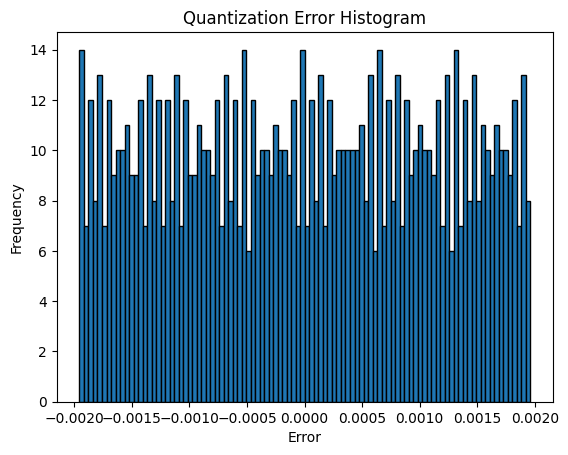

Mean error: -1.5031545785859635e-08
Standard deviation : 0.001132344827055931


In [787]:
# Situation 1
array = np.linspace(0, 0.5, 1000, dtype=np.float32)
min_range = 0
max_range = 1
display_error_histogram(array, min_range, max_range)
quantization_error_stats(array, min_range, max_range)

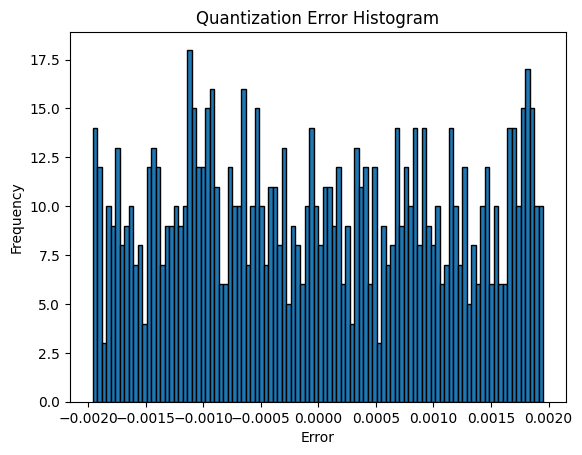

Mean error: -3.8479993236251175e-06
Standard deviation : 0.0011439853115007281


In [788]:
# Situation 1bis
array = np.random.uniform(0, 1, 1000).astype(np.float32)
min_range = 0
max_range = 1
display_error_histogram(array, min_range, max_range)
quantization_error_stats(array, min_range, max_range)

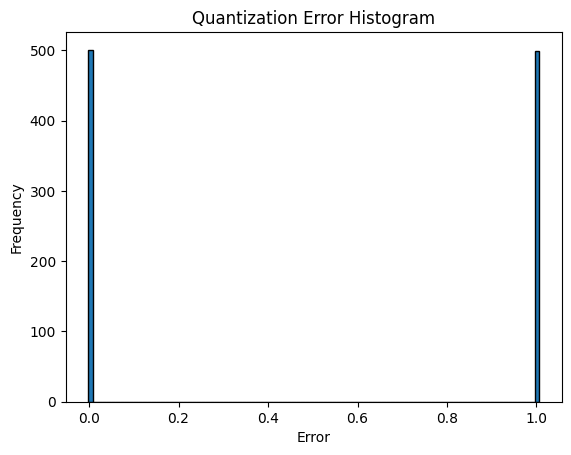

Mean error: 0.5009568333625793
Standard deviation : 0.5019811391830444


In [789]:
# Situation 2
array = np.linspace(0, 2, 1000, dtype=np.float32)
min_range = 0
max_range = 1
display_error_histogram(array, min_range, max_range)
quantization_error_stats(array, min_range, max_range)

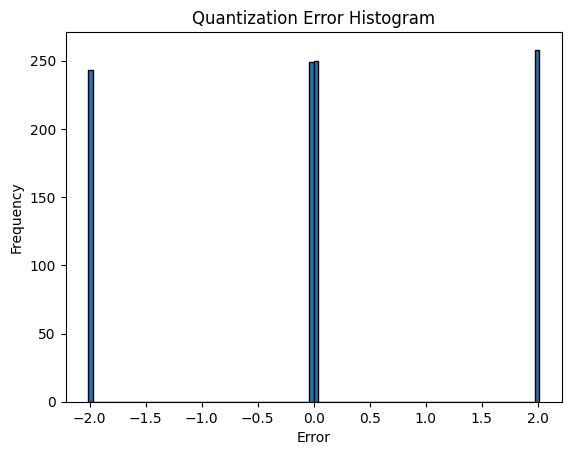

Mean error: 0.030105333775281906
Standard deviation : 1.4207834005355835


In [790]:
# Situation 3
array = np.random.uniform(-2, 2, 1000).astype(np.float32)
min_range = -1
max_range = 1
display_error_histogram(array, min_range, max_range)
quantization_error_stats(array, min_range, max_range)

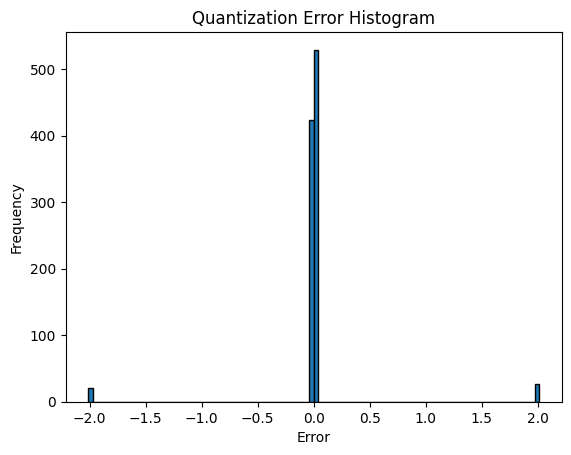

Mean error: 0.012168971821665764
Standard deviation : 0.43982189893722534


In [791]:
# Situation 4 :
array = np.random.normal(0, 0.5, 1000).astype(np.float32)
min_range = -1
max_range = 1
display_error_histogram(array, min_range, max_range)
quantization_error_stats(array, min_range, max_range)

## Post training quantization from scratch

In [675]:
import copy

def quantize_model_naive(model):
    model_q = copy.deepcopy(model)
    # find minumum value 
    for param in model_q.parameters():
        param.data = torch.round(param.data).to(torch.int8).to(torch.float32)

    return model_q


In [676]:
model_q = quantize_model_naive(model)
print("Original accuracy:", model.evaluate(test_loader))
print("Quantized naive accuracy:", model_q.evaluate(test_loader))


Original accuracy: 0.9764
Quantized naive accuracy: 0.098


Cela ne fonctionne pas du tout, on a complementement casse le modele. 

In [681]:
def quantize_model_static(model, train_loader):
    model_q = copy.deepcopy(model)
    min = float('inf')
    max = float('-inf')

    for name, param in model_q.named_parameters():
        min_elem = torch.min(param.data).item()
        max_elem = torch.max(param.data).item()
        min = min_elem if min_elem < min else min
        max = max_elem if max_elem > max else max

    for param in model_q.parameters():
        value = param.data.cpu().numpy()
        quantized_param = quantize(value, min, max, zero = 0)
        dequantized_param = to_float(quantized_param, min, max)
        param.data = torch.from_numpy(dequantized_param).to(torch.float32)

    return model_q

model_q_static = quantize_model_static(model, train_loader)
print("Original accuracy:", model.evaluate(test_loader))
print("Quantized static accuracy:", model_q_static.evaluate(test_loader))

Original accuracy: 0.9764
Quantized static accuracy: 0.9762


In [682]:
def quantize_model_each_layer(model, train_loader):
    model_q = copy.deepcopy(model)

    for name, param in model_q.named_parameters():
        min_elem = torch.min(param.data).item()
        max_elem = torch.max(param.data).item()

        value = param.data.cpu().numpy()
        quantized_param = quantize(value, min_elem, max_elem, zero = 0)
        dequantized_param = to_float(quantized_param, min_elem, max_elem)
        param.data = torch.from_numpy(dequantized_param).to(torch.float32)

    return model_q
model_q_each_layer = quantize_model_each_layer(model, train_loader)
print("Original accuracy:", model.evaluate(test_loader))
print("Quantized each layer accuracy:", model_q_each_layer.evaluate(test_loader))

Original accuracy: 0.9764
Quantized each layer accuracy: 0.9762


Cela marche -t-il ? Sinon que suggerez vous pour resoudre le probleme ?

On n'est pas sur une mega reussite, mais c'est deja mieux que le modele quantifie naiveement.
Pour ameliorer les choses, on pourrait essayer d'utiliser une quantification symetrique (centrer autour de 0).Malgré la quantization par couche, la précision reste inférieure au modèle original. Cela s’explique par la perte d’information due à la réduction de précision. Pour améliorer les résultats, il serait nécessaire d’introduire la quantization des activations ou d’utiliser la Quantization Aware Training (QAT) afin que le réseau apprenne à compenser les effets de la quantization.

Que faudrait-il ajouter à l'approche précédente pour quantifier aussi les activations des couches ? 

Comment obtenir les bonnes plages de quantization à utiliser ? 

faire en sorte de  faire une quantization des weights et des activations de votre modèle

In [664]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def quantize_tensor(x: torch.Tensor, min_val: float, S: float, qmin: float) -> torch.Tensor:
    return torch.round((x - min_val) / S + qmin)

def dequantize_tensor(Q: torch.Tensor, min_val: float, S: float, qmin: float) -> torch.Tensor:
    return (Q - qmin) * S + min_val


class QuantizeSTE(MLP):
    def __init__(self, pretrained_state_dict=None, bits=8):
        super().__init__()
        if pretrained_state_dict is not None:
            try:
                self.load_state_dict(pretrained_state_dict)
            except Exception as e:
                print("Couldn't load pretrained_state_dict:", e)

        self.bits = bits
        self.qmin = -(1 << (bits - 1))
        self.qmax = (1 << (bits - 1)) - 1

    
    def quantize_activation(self, x: torch.Tensor) -> torch.Tensor:
        min_val = x.min()
        max_val = x.max() 

        S = (max_val - min_val) / (self.qmax - self.qmin)

        # Quantization
        Q = quantize_tensor(x, min_val, S, self.qmin)
        # Dequantization
        x_dequant = dequantize_tensor(Q, min_val, S, self.qmin)
        # Straight-Through Estimator
        x_q = (x_dequant - x).detach() + x # d/dx = 1 / and return value = x_dequant !!!!

        return x_q

    def forward(self, x):
        x = x.view(-1, 28*28)

        x = self.fc1(x)
        x = self.quantize_activation(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.quantize_activation(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.quantize_activation(x)
        return x
    
    def quantize_state_dict(self):
        q_state_dict = {}
        qparams = {}

        for name, param in self.state_dict().items():
            min_val = param.min().item()
            max_val = param.max().item()
            S = (max_val - min_val) / (self.qmax - self.qmin + 1e-8)

            q = torch.round((param - min_val) / S + self.qmin).to(torch.int8)

            q_state_dict[name] = q
            qparams[name] = (S, min_val)

        return q_state_dict, qparams


    def quantize_model_STE(self):
        model_q = copy.deepcopy(self)
        model_q.qparams = {} 

        for name, param in model_q.named_parameters():
            min_elem = torch.min(param.data).item()
            max_elem = torch.max(param.data).item()
            S = (max_elem - min_elem) / (model_q.qmax - model_q.qmin + 1e-8)

            value = quantize_tensor(param.data, min_elem, S, model_q.qmin)
            param.data = value

            model_q.qparams[name] = (min_elem, S)

        return model_q
    
    def dequantize_model_STE(self):
        model_deq = copy.deepcopy(self)

        for name, param in model_deq.named_parameters():
            min_elem, S = model_deq.qparams[name]
            value = dequantize_tensor(param.data, min_elem, S, self.qmin)
            param.data = value

        return model_deq
    
    def save_quantized_model(self, filename):
        q_state_dict, qparams = self.quantize_state_dict()
        torch.save({'q_state_dict': q_state_dict, 'qparams': qparams, 'bits': self.bits}, filename)

    @staticmethod
    def load_quantized_model(filename):
        file = torch.load(filename)
        q_state_dict = file['q_state_dict']
        qparams = file['qparams']

        model = QuantizeSTE(bits=file['bits'])
        model.load_state_dict(q_state_dict)

        model.qparams = qparams

        return model

model_ste = QuantizeSTE(pretrained_state_dict=None)
optimizer_ste = optim.Adam(model_ste.parameters(), lr=1e-3)
criterion_ste = nn.CrossEntropyLoss()
model_ste.compile(optimizer_ste, criterion_ste)

model_ste.fit(train_loader, epochs=5)

Epoch 1/5, Loss: 0.3452
Epoch 2/5, Loss: 0.1391
Epoch 3/5, Loss: 0.0951
Epoch 4/5, Loss: 0.0722
Epoch 5/5, Loss: 0.0563


In [587]:
acc = model_ste.evaluate(test_loader)
print(f"Test accuracy: {acc}")

Test accuracy: 0.9732


In [598]:

model_quantize = model_ste.quantize_model_STE()

model_dequantize = dequantize_model_STE(model_quantize)
print("Original STE accuracy:", model_ste.evaluate(test_loader))
print("Quantized STE accuracy:", model_dequantize.evaluate(test_loader))

Original STE accuracy: 0.9732
Quantized STE accuracy: 0.973


Et la ca fonctionne on a bien un model qui lorsqu'il est quantifier puis dequantifier retrouve des performances proches de l'original !!!

On peut tenter de les sauvegarder pour voir la place que l'on gagne en theorie x4. Attention pour des raisons de tensorflow on a encore des float32 dans les fichiers.

In [606]:
q_state_dict, qparams = model_ste.quantize_state_dict()

In [609]:
save_quantized_model(model_ste, "quantized_model_ste.pth")
torch.save({'state_dict': model_ste.state_dict()}, "dequantized_model_ste.pth")

import os
size_quantized = os.path.getsize("quantized_model_ste.pth")
size_dequantized = os.path.getsize("dequantized_model_ste.pth")
print(f"Size of quantized model: {size_quantized / 1024:.2f} KB")
print(f"Size of dequantized model: {size_dequantized / 1024:.2f} KB")

Size of quantized model: 109.97 KB
Size of dequantized model: 430.37 KB


In [611]:
model_loaded = load_quantized_model("quantized_model_ste.pth", bits=8)
dequantized_model = dequantize_model_STE(model_loaded) # not perfect 
print("Loaded quantized model accuracy:", dequantized_model.evaluate(test_loader))

Loaded quantized model accuracy: 0.973


Normal que les performances ne soient pas mieux qu'avec le modele de base car le model fonctionne avec des float32 qui peuvent etre convertis en 

In [667]:
from torch.ao.quantization import (get_default_qat_qconfig,
                                  prepare_qat,
                                  convert,
                                  fuse_modules)


# --- Setup ---
device = torch.device("cpu")  # QAT training done on CPU/GPU as usual; conversion for backend qnnpack is CPU runtime
torch.backends.quantized.engine = "qnnpack"  # pour ARM; sur x86 => "fbgemm"

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # lr plus petit pour QAT fine-tuning
criterion = nn.CrossEntropyLoss()
model.compile(optimizer, criterion)

# --- Fusion (facultatif mais recommandé) ---
# On fuse Linear + ReLU si possible (nommes comme ci-dessus)
# pour un MLP on fuse ['fc1','relu1'] et ['fc2','relu2'] si nécessaire
# attention: fuse_modules attend que les modules existent au même niveau.
fused_model = copy.deepcopy(model)
fuse_modules(fused_model, [['fc1', 'relu1'], ['fc2', 'relu2']], inplace=True)

# --- QAT preparation ---
qat_model = fused_model
qat_model.qconfig = get_default_qat_qconfig("qnnpack")
prepare_qat(qat_model, inplace=True)  # insère fake-quant / observers

# --- QAT training / fine-tune ---
# Important: pour QAT, lr réduit, momentum/weight decay adaptés. 5-20 epochs typiquement.
n_epochs_qat = 10
for epoch in range(n_epochs_qat):
    avg_loss = qat_model.fit(train_loader)  # utilise la méthode fit_epoch définie
    acc = qat_model.evaluate(test_loader)

# Optionnel : "freeze" observers avant conversion (réduit variance)
# torch.ao.quantization.disable_observer(qat_model)
# torch.ao.quantization.freeze_bn_stats(qat_model)  # si batchnorm present

# --- Convert to quantized model (int8 modules) ---
qat_model.eval()
quantized_model = convert(qat_model, inplace=False)  # retourne une copie quantized

# --- Test / comparer performances (accuracy) ---
quantized_model.eval()
with torch.no_grad():
    acc_q = quantized_model.evaluate(test_loader)
    print("Quantized model accuracy:", acc_q)

# Tu peux aussi mesurer la différence logits / outputs float vs quant pour debug
# --- Export: TorchScript + optimize for mobile ---
scripted = torch.jit.script(quantized_model)
# Optionnel: optimiser pour mobile
try:
    from torch.utils.mobile_optimizer import optimize_for_mobile
    scripted_optimized = optimize_for_mobile(scripted)
    scripted_optimized.save("mlp_qat_int8_mobile.pt")
    print("Saved optimized mobile scripted quantized model -> mlp_qat_int8_mobile.pt")
except Exception as e:
    # si mobile optimizer non disponible, sauvegarde le scripted normal
    scripted.save("mlp_qat_int8.pt")
    print("Saved scripted quantized model -> mlp_qat_int8.pt (optimize_for_mobile failed):", e)


/tmp/ipykernel_12252/1188474859.py:26: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepare_qat(qat_model, inplace=True)  # insère fake-quant / observers


Epoch 1/1, Loss: 1.0723
Epoch 1/1, Loss: 0.3569
Epoch 1/1, Loss: 0.2871
Epoch 1/1, Loss: 0.2532
Epoch 1/1, Loss: 0.2282
Epoch 1/1, Loss: 0.2078
Epoch 1/1, Loss: 0.1903
Epoch 1/1, Loss: 0.1754
Epoch 1/1, Loss: 0.1630
Epoch 1/1, Loss: 0.1519


/tmp/ipykernel_12252/1188474859.py:41: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = convert(qat_model, inplace=False)  # retourne une copie quantized


NotImplementedError: Could not run 'quantized::linear_relu' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_relu' is only available for these backends: [Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMAIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastMAIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at /pytorch/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at /pytorch/aten/src/ATen/native/quantized/cpu/qlinear.cpp:1603 [kernel]
QuantizedCUDA: registered at /pytorch/aten/src/ATen/native/quantized/cudnn/Linear.cpp:359 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:387 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:115 [backend fallback]
ADInplaceOrView: fallthrough registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:104 [backend fallback]
AutogradOther: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMPS: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:95 [backend fallback]
AutogradXPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:108 [backend fallback]
AutogradLazy: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:91 [backend fallback]
AutogradMTIA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMAIA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:99 [backend fallback]
Tracer: registered at /pytorch/torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:324 [backend fallback]
AutocastMTIA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:468 [backend fallback]
AutocastMAIA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:506 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:544 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]
